# Initialize

In [71]:
%matplotlib notebook
import numpy as np
from scipy.special import wofz
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Functions

In [72]:
def p_to_Conc(p, T):
    """ Returns the concentration based on a given pressure (Torr) and temperature (K) """
    return ((p*133.322)/(R*T))*Na

def poly(x,*args):
    f_poly = 0
    for count, coef in enumerate(args):
        f_poly = f_poly + coef*x**count
    return f_poly

def G_HWHM(v_cent, T, M):
    """ Return Gaussian HWHM alpha based on line params """
    return (v_cent/c) * np.sqrt((2*Na*kb*T*np.log(2))/M)

def L_HWHM(g_air, g_self, p, p_self):
    """ Return Loren HWHM alpha based on line params """
    p_self = p_self * 0.00132
    p = p * 0.00132
    return g_air*(p-p_self)+g_self*p_self

def V_func(x, p_self, v_cent, M, g_air, g_self, S, v):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.
    """

    
    sigma = (G_HWHM(v, Temp, M) / np.sqrt(2 * np.log(2)))/mA_wn_conv
    gamma = L_HWHM(g_air, g_self, p, p_self)/mA_wn_conv

    V_f = ((np.real(wofz(((x-v_cent) + 1j*gamma)/sigma/np.sqrt(2))) / sigma \
              /np.sqrt(2*np.pi))*S)
    
    return V_f

def fit_func(x, p_self, v1, v2, v3, v4, *args):
    
    return np.exp((-1)*(V_func(x,p_self,v1,M_S1,g_air_S1L1,g_self_S1L1,S_S1L1,v_S1L1) \
        +V_func(x,p_self,v2,M_S1,g_air_S1L2,g_self_S1L2,S_S1L2,v_S1L2) \
        +V_func(x,p_self,v3,M_S1,g_air_S1L3,g_self_S1L3,S_S1L3,v_S1L3) \
        +V_func(x,p_self,v4,M_S1,g_air_S1L4,g_self_S1L4,S_S1L4,v_S1L4)) \
        *PL*p_to_Conc(p_self,Temp)/mA_wn_conv)*poly(x,*args)

# Const and Params

In [73]:
""" Constants """
c = 2.998e10 #Speed of light, cm s-1
Na = 6.02214129e23 #Avogadro's number, mol-1
kb = 1.38064852e-16 # Boltzman Constant, cm2 g s-1 K-1
R = 8314000 # Gas Constant
Temp = 298 # Temp, K
p = 10 # Pressure, Torr
PL = 10 # path length,  cm
mA_wn_conv = 2.476E-02 # Conversion of mA to wavenumber


""" Species/Line params """
#Species 1 - H2O
M_S1 = 18.01528 # g mol-1
##Line 1
v_S1L1 = 3447.237010 # cm-1
g_air_S1L1 = 0.0728 # air broadening
g_self_S1L1 = 0.426 # self broadening
S_S1L1 = 5.381e-21 # Line strength, (molecule-1 cm2)/(cm-1)
##Line 2
v_S1L2 = 3447.076453 # cm-1
g_air_S1L2 = 0.0728 # air broadening
g_self_S1L2 = 0.412 # self broadening
S_S1L2 = 1.771e-21 # Line strength, (molecule-1 cm2)/(cm-1)
##Line 3
v_S1L3 = 3446.941250 # cm-1
g_air_S1L3 = 0.0862 # air broadening
g_self_S1L3 = 0.473 # self broadening
S_S1L3 = 1.836e-21 # Line strength, (molecule-1 cm2)/(cm-1)
##Line 4
v_S1L4 = 3446.884540 # cm-1
g_air_S1L4 = 0.049 # air broadening
g_self_S1L4 = 0.288 # self broadening
S_S1L4 = 5.297e-22 # Line strength, (molecule-1 cm2)/(cm-1)


## Import data and plot with initial guess

<IPython.core.display.Javascript object>


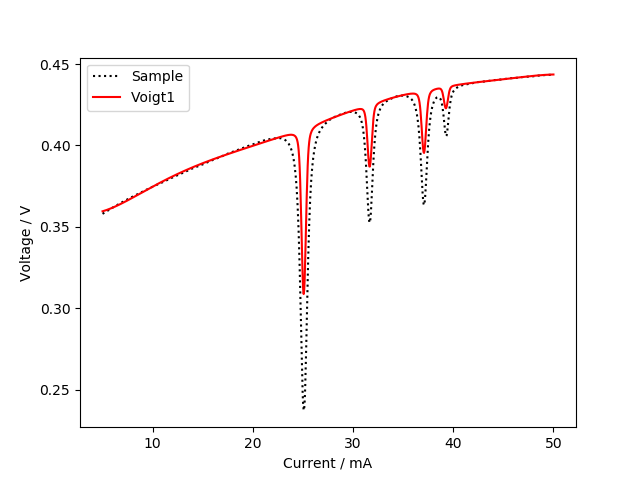

In [74]:
samp_file = r"C:\Users\winiberg\Desktop\raw_Data_Test.txt"
temp_data = np.genfromtxt(samp_file, dtype='f8')
x_data, samp_data = np.hsplit(temp_data,2)

#Flatten arrays so that fitting function works!
x_data = x_data.flatten()
samp_data = samp_data.flatten()

x_data = x_data[100:]
samp_data = samp_data[100:]

plt.plot(x_data, samp_data, ls=':', c='k', label='Sample')
plt.plot(x_data, fit_func(x_data,2.5,25.078,31.659,37.0766,39.2675,3.76445119e-01,-1.17878647e-02,2.51174909e-03,-2.05392076e-04,8.89943651e-06,-2.10900366e-07,2.57586389e-09,-1.26870667e-11), c='r', label='Voigt1')
plt.xlabel('Current / mA')
plt.ylabel('Voltage / V')
plt.legend()
plt.show()

# Fit Data

[  7.46421405e+00   2.50914433e+01   3.16616611e+01   3.70853921e+01
   3.93002071e+01   3.76445119e-01  -1.17878647e-02   2.51174909e-03
  -2.05392076e-04   8.89943651e-06  -2.10900366e-07   2.57586389e-09
  -1.26870667e-11]
2.41885904434e+17


<IPython.core.display.Javascript object>


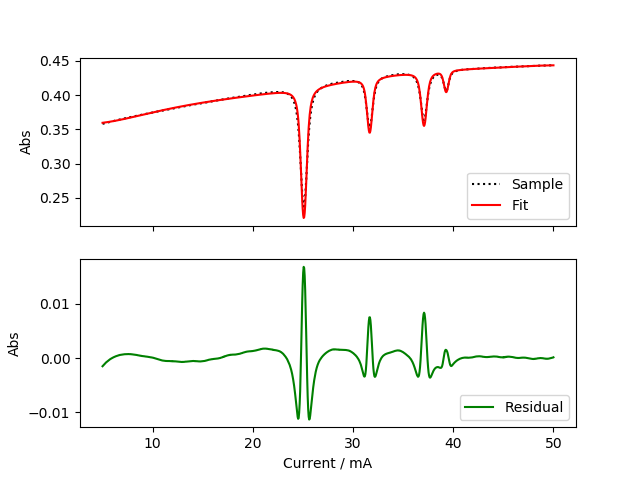

In [75]:
%matplotlib notebook
popt, pconv = curve_fit(fit_func,x_data,samp_data,p0=[1,25.078,31.659,37.0766,39.2675,0.24263,0.027775,-0.0019803,6.4855e-5,-9.41e-7,4.9144e-9,4.9144e-11,4.9144e-9])

print(popt)
Conc1 = popt[0]
Offset = popt[1]
print(p_to_Conc(Conc1,Temp))

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x_data, samp_data, ls=':', c='k', label='Sample')
axarr[0].plot(x_data, fit_func(x_data, *popt), c='r', label='Fit')
axarr[1].plot(x_data, (samp_data-fit_func(x_data, *popt)), c='g', label='Residual')
for ax in axarr.flat:
    ax.set(xlabel='Current / mA', ylabel='Abs')
    ax.label_outer()
    ax.legend(loc="lower right")
plt.show()
